## 1. Importações e Configuração
Adicionamos rembg para limpar a imagem e cv2 para calcular matematicamente as formas (momentos).

In [ ]:
import cv2
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

IMG_SIZE = 64

In [6]:
def extrair_features_sobel(caminho_imagem):
    try:
        # 1. Ler em Cinza
        img = cv2.imread(caminho_imagem, cv2.IMREAD_GRAYSCALE)
        if img is None: return None
        
        # 2. Redimensionar e aplicar Blur (reduz ruído antes do Sobel)
        img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img_blur = cv2.GaussianBlur(img_resized, (3, 3), 0)
        
        # 3. Aplicar Sobel
        # cv2.CV_64F permite valores negativos (derivadas negativas), essencial para o cálculo correto
        sobelx = cv2.Sobel(img_blur, cv2.CV_64F, 1, 0, ksize=3) # Derivada em X
        sobely = cv2.Sobel(img_blur, cv2.CV_64F, 0, 1, ksize=3) # Derivada em Y
        
        # 4. Calcular Magnitude (Força das bordas)
        magnitude = cv2.magnitude(sobelx, sobely)
        
        # --- FEATURE SET 1: Estatísticas das Bordas ---
        # Cães e gatos podem ter densidades de bordas diferentes devido à pelagem
        mean_edge = np.mean(magnitude)
        std_edge = np.std(magnitude)
        
        # --- FEATURE SET 2: Momentos de Hu na Magnitude ---
        # Tratamos a imagem de bordas como uma "forma" para calcular geometria
        # Normalizamos a magnitude para 0-255 para calcular momentos
        mag_norm = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        moments = cv2.moments(mag_norm)
        hu_moments = cv2.HuMoments(moments).flatten()
        
        # Log transform para estabilizar os Hu Moments (evitar valores minúsculos)
        # Adicionamos 1e-10 para evitar log(0)
        hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-10)
        
        # --- FEATURE SET 3: Raw Pixels da Magnitude (Achatados) ---
        # Usamos a própria imagem de bordas como feature visual
        raw_edges = magnitude.flatten()
        
        # Concatenar tudo: [Hu(7), Media(1), Std(1), Pixels(4096)]
        features = np.concatenate([hu_moments, [mean_edge, std_edge], raw_edges])
        
        return features

    except Exception as e:
        print(f"Erro em {caminho_imagem}: {e}")
        return None

# Teste visual rápido para ver o Sobel
print("Função de Sobel definida.")

Função de Sobel definida.


In [7]:
raw_data = []
labels = []

# Ajuste os caminhos conforme sua estrutura real
caminhos = {
    'dog': glob.glob('./datasets/PetImages/Dog/*.jpg'),
    'cat': glob.glob('./datasets/PetImages/Cat/*.jpg'),
}

print("Iniciando processamento com Sobel...")

for label_name, lista_arquivos in caminhos.items():
    print(f"Processando {label_name}: {len(lista_arquivos)} imagens encontradas.")
    
    for arquivo in lista_arquivos:
        feat = extrair_features_sobel(arquivo)
        if feat is not None:
            raw_data.append(feat)
            labels.append(label_name)

# Verificação de segurança para evitar o erro anterior
if len(raw_data) == 0:
    print("ERRO CRÍTICO: Nenhuma imagem processada. Verifique os caminhos no glob.")
else:
    print(f"Sucesso! {len(raw_data)} imagens transformadas em vetores de features.")

Iniciando processamento com Sobel...
Processando dog: 12499 imagens encontradas.


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9


Processando cat: 12499 imagens encontradas.


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


Sucesso! 24997 imagens transformadas em vetores de features.


Treinando modelo SVM...

--- Resultado Final ---
Acurácia: 66.00%

Relatório de Classificação:
              precision    recall  f1-score   support

         cat       0.66      0.64      0.65      2485
         dog       0.66      0.68      0.67      2515

    accuracy                           0.66      5000
   macro avg       0.66      0.66      0.66      5000
weighted avg       0.66      0.66      0.66      5000



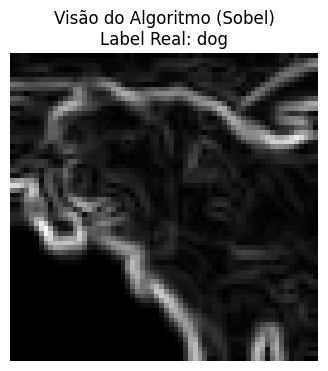

In [8]:
if len(raw_data) > 0:
    # 1. Preparar dados
    X = np.array(raw_data)
    y = np.array(labels)

    # 2. Divisão (Garante que não está vazio)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 3. Normalização (StandardScaler)
    # Remove a média e escala para variância unitária
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 4. Treinar SVM
    print("Treinando modelo SVM...")
    model = SVC(kernel='rbf', C=1.0) # RBF costuma ser melhor para imagens que Linear
    model.fit(X_train_scaled, y_train)

    # 5. Avaliar
    pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, pred)

    print(f"\n--- Resultado Final ---")
    print(f"Acurácia: {acc*100:.2f}%")
    print("\nRelatório de Classificação:")
    print(classification_report(y_test, pred))
    
    # 6. Exibir uma imagem processada (Sobel) para você entender o que a máquina viu
    # Pega o primeiro exemplo do teste
    exemplo_idx = 0
    # Recupera a parte da imagem (removemos os 9 primeiros stats)
    img_sobel_recuperada = X_test[exemplo_idx][9:].reshape(IMG_SIZE, IMG_SIZE)
    
    plt.figure(figsize=(4,4))
    plt.imshow(img_sobel_recuperada, cmap='gray')
    plt.title(f"Visão do Algoritmo (Sobel)\nLabel Real: {y_test[exemplo_idx]}")
    plt.axis('off')
    plt.show()